<a href="https://colab.research.google.com/github/atikahlestar/Machine-Learning-ML-/blob/atikahlestar-patch-1/1_Klasifikasi_Gambar_Hewan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Hewan


## **Klasifikasi Gambar Hewan**

**Objective:**

Membangun sebuah model menggunakan CNN yang dapat mengklasifikasikan jenis hewan berdasarkan gambar.

**Sumber Dataset**
  
 https://www.kaggle.com/datasets/asaniczka/mammals-image-classification-dataset-45-animals


## **1. Import Libraries**

In [ ]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [ ]:
# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

In [ ]:
# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise


In [ ]:
!pip install tensorflowjs --upgrade

In [ ]:
# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.applications import MobileNetV2

In [ ]:
# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## **2. Data Loading**

In [ ]:
# Unggah file kaggle.json yang berisi API key untuk autentikasi ke Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"atikahlestari","key":"2f4cea15105ac0d826a712ae88922c5a"}'}

In [ ]:
# Hapus folder sebelumnya jika ada
!rm -rf mammals_image_classification/

In [ ]:
# Unduh dataset dari Kaggle
!kaggle datasets download -d asaniczka/mammals-image-classification-dataset-45-animals

Dataset URL: https://www.kaggle.com/datasets/asaniczka/mammals-image-classification-dataset-45-animals
License(s): ODC Attribution License (ODC-By)
mammals-image-classification-dataset-45-animals.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!kaggle datasets download -d asaniczka/mammals-image-classification-dataset-45-animals --force

Dataset URL: https://www.kaggle.com/datasets/asaniczka/mammals-image-classification-dataset-45-animals
License(s): ODC Attribution License (ODC-By)
 99% 182M/185M [00:01<00:00, 165MB/s]
100% 185M/185M [00:01<00:00, 180MB/s]


In [ ]:
!ls

 best_mammals_model.keras   kaggle.json						  sample_data
'kaggle (1).json'	    mammals-image-classification-dataset-45-animals.zip


In [ ]:
# Ekstrak file zip dataset
!unzip mammals-image-classification-dataset-45-animals.zip -d mammals_image_classification/

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: mammals_image_classification/mammals/red_panda/red_panda-0250.jpg  
  inflating: mammals_image_classification/mammals/red_panda/red_panda-0251.jpg  
  inflating: mammals_image_classification/mammals/red_panda/red_panda-0252.jpg  
  inflating: mammals_image_classification/mammals/red_panda/red_panda-0253.jpg  
  inflating: mammals_image_classification/mammals/red_panda/red_panda-0254.jpg  
  inflating: mammals_image_classification/mammals/red_panda/red_panda-0255.jpg  
  inflating: mammals_image_classification/mammals/red_panda/red_panda-0256.jpg  
  inflating: mammals_image_classification/mammals/red_panda/red_panda-0257.jpg  
  inflating: mammals_image_classification/mammals/red_panda/red_panda-0258.jpg  
  inflating: mammals_image_classification/mammals/red_panda/red_panda-0259.jpg  
  inflating: mammals_image_classification/mammals/red_panda/red_panda-0260.jpg  
  inflating: mammals_image_classification/mammals/

## **3. Gabungkan Data Train dan Data Test ke Direktori yang Sama**

In [ ]:
# Direktori awal dari dataset Food Image Classification
dataset_dir = "mammals_image_classification"

In [ ]:
# Direktori baru untuk dataset gabungan
combined_dir = "mammals_image_classification/combined_dataset"

In [ ]:
# Buat direktori gabungan jika belum ada
os.makedirs(combined_dir, exist_ok=True)

In [ ]:
# Iterasi melalui setiap folder dalam dataset
for category in os.listdir(dataset_dir):
    category_dir = os.path.join(dataset_dir, category)

    # Cek apakah path adalah direktori (bukan file lainnya)
    if os.path.isdir(category_dir):
        # Path tujuan untuk kategori tersebut di direktori gabungan
        combined_category_dir = os.path.join(combined_dir, category)

        # Salin semua file ke folder gabungan, termasuk isi subfolder
        shutil.copytree(category_dir, combined_category_dir, dirs_exist_ok=True)

print(f"Dataset berhasil digabungkan ke direktori: {combined_dir}")


Dataset berhasil digabungkan ke direktori: mammals_image_classification/combined_dataset


## **4. Pembagian Dataset Menjadi 80% Training dan 20% Testing dengan Augmentasi Data**

In [ ]:
# Direktori dataset gabungan
dataset_dir = "mammals_image_classification/combined_dataset"

In [ ]:
# Parameter untuk preprocessing dan augmentasi
img_height, img_width = 150, 150
batch_size = 32

In [ ]:
# Augmentasi dan normalisasi data untuk train set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    validation_split=0.2
)

In [ ]:
# Normalisasi data untuk test set
test_datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

In [ ]:
# Membuat generator untuk training dan testing
train_data = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

test_data = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

Found 11001 images belonging to 2 classes.
Found 2750 images belonging to 2 classes.


In [ ]:
# Jumlah kelas dalam dataset
num_classes = len(train_data.class_indices)
print(f"Jumlah kelas: {num_classes}")

Jumlah kelas: 2


## **5. Membangun Model CNN**

In [ ]:
# Load MobileNetV2 sebagai feature extractor
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights="imagenet")
base_model.trainable = True  # Unlock sebagian layer untuk fine-tuning

<ipython-input-24-b634109a3026>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights="imagenet")


In [ ]:
# Fine-tune dari blok ke-100 ke atas
for layer in base_model.layers[:100]:
    layer.trainable = False

In [ ]:
# Model Sequential dengan Conv2D, Pooling Layer, dan BatchNormalization
model = Sequential([
    base_model,

    Conv2D(256, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(1024, activation="relu"),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

In [ ]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 5, 5, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 5, 256)           │       2,949,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 2, 2, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 1, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           2,050 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,638,082 (21.51 MB)

 Trainable params: 5,240,770 (19.99 MB)

 Non-trainable params: 397,312 (1.52 MB)

## **6. Mengimplementasikan Callback**

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)

In [ ]:
checkpoint = ModelCheckpoint(
    "best_mammals_model.keras",
    monitor="val_accuracy",
    save_best_only=True
)

## **7. Melatih Model**

In [ ]:
history = model.fit(
    train_data,
    epochs=100,
    validation_data=test_data,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 715s 2s/step - accuracy: 0.9011 - loss: 0.2294 - val_accuracy: 1.0000 - val_loss: 0.0058 - learning_rate: 1.0000e-04
Epoch 2/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 747s 2s/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 3/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 688s 2s/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 0.0010 - learning_rate: 1.0000e-04
Epoch 4/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 749s 2s/step - accuracy: 1.0000 - loss: 7.8384e-04 - val_accuracy: 1.0000 - val_loss: 6.5663e-04 - learning_rate: 1.0000e-04
Epoch 5/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 696s 2s/step - accuracy: 1.0000 - loss: 4.5939e-04 - val_accuracy: 1.0000 - val_loss: 4.2338e-04 - learning_rate: 1.0000e-04
Epoch 6/100
344/344 ━━━━━━━━━━━━━━━━━━━━ 691s 2s/step - accuracy: 1.0000 - loss: 2.7535e-04 - val_accuracy: 1.0000 - val_loss: 3.0074e-04 - learning_rate: 1.0000e-04
Epoch 7/100
344/344 ━━━━━━━━

## **8. Evaluasi Model**

In [ ]:
# Evaluasi pada training dan testing set
train_loss, train_acc = model.evaluate(train_data)
test_loss, test_acc = model.evaluate(test_data)

print(f"Akurasi Training Set: {train_acc * 100:.2f}%")
print(f"Akurasi Testing Set: {test_acc * 100:.2f}%")

344/344 ━━━━━━━━━━━━━━━━━━━━ 319s 928ms/step - accuracy: 1.0000 - loss: 0.0036
86/86 ━━━━━━━━━━━━━━━━━━━━ 67s 783ms/step - accuracy: 1.0000 - loss: 0.0058
Akurasi Training Set: 100.00%
Akurasi Testing Set: 100.00%


## **9. Visualisasi Akurasi dan Loss**

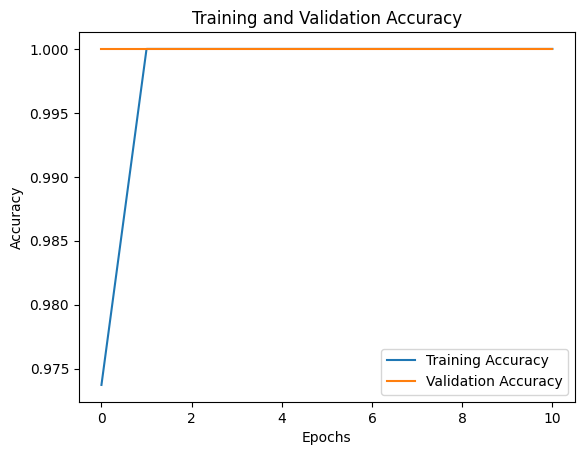

In [ ]:
# Plot akurasi
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

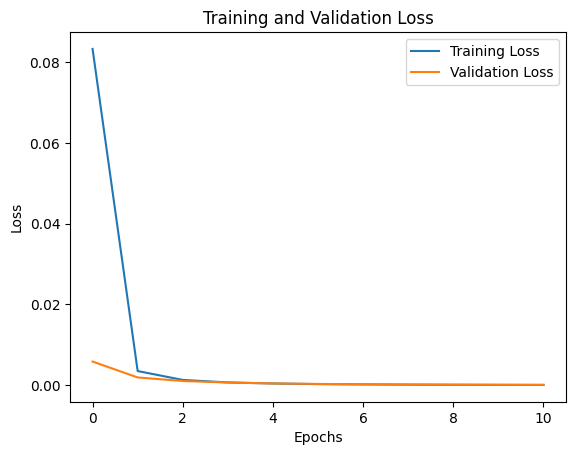

In [ ]:
# Plot loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


## **10. Menyimpan Model**

### **a. SavedModel**

In [ ]:
# Simpan model dalam format SavedModel
saved_model_path = "/content/saved_model"
model.export(saved_model_path)  # Gunakan model.export()
print(f"Model disimpan di: {saved_model_path}")

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132911156985488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132913791503248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132914008402512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132913791504208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132914008402704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132914008397712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132911122026896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132911122027472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132911156985296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132911122026704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132911

In [ ]:
# Kompres folder menjadi .zip agar bisa diunduh
shutil.make_archive("/content/saved_model", 'zip', "/content/saved_model")

# Unduh file zip
files.download("/content/saved_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **b. TF-Lite**

In [ ]:
# Konversi ke TF-Lite
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

In [ ]:
# Simpan model hasil konversi
tflite_model_path = "/content/mammals_model.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"Model TF-Lite disimpan di: {tflite_model_path}")

Model TF-Lite disimpan di: /content/mammals_model.tflite


In [ ]:
from google.colab import files
files.download(tflite_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **c. TFJS**

In [ ]:
saved_model_path = "/content/saved_model"
model.export(saved_model_path)  # Use model.export() for SavedModel
print(f"Model disimpan di: {saved_model_path}")

Saved artifact at '/content/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  132911156985488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132913791503248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132914008402512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132913791504208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132914008402704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132914008397712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132911122026896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132911122027472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132911156985296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132911122026704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132911

In [ ]:
# Konversi ke format TensorFlow.js (TFJS)
tfjs_model_path = "/content/tfjs_model"

!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model /content/saved_model /content/tfjs_model

print(f"Model TFJS disimpan di: {tfjs_model_path}")

2025-02-07 00:37:55.961021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738888675.990669   67781 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738888675.998843   67781 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-02-07 00:38:06.467904: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1738888688.145149   67781 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [ ]:
!ls -R /content/tfjs_model

/content/tfjs_model:
group1-shard1of6.bin  group1-shard3of6.bin  group1-shard5of6.bin  model.json
group1-shard2of6.bin  group1-shard4of6.bin  group1-shard6of6.bin


In [ ]:
import shutil
from google.colab import files

# Kompres folder TFJS
shutil.make_archive("/content/tfjs_model", 'zip', "/content/tfjs_model")


'/content/tfjs_model.zip'

In [ ]:
# Unduh file ZIP
files.download("/content/tfjs_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **11. Inference Menggunakan Model TF-Lite**

In [ ]:
import numpy as np
from PIL import Image

In [ ]:
# Load model TF-Lite
interpreter = tf.lite.Interpreter(model_path='mammals_model.tflite')
interpreter.allocate_tensors()

In [ ]:
# Mendapatkan detail input dan output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
# Resolusi input dari model
img_width, img_height = input_details[0]['shape'][1], input_details[0]['shape'][2]

In [ ]:
# Fungsi preprocessing gambar untuk inference
def preprocess_image(image_path):
    """
    Mengubah gambar menjadi format yang sesuai untuk input model.
    """
    img = Image.open(image_path).resize((img_width, img_height))  # Resize gambar
    img = np.array(img, dtype=np.float32) / 255.0  # Normalisasi piksel & ubah ke float32
    img = np.expand_dims(img, axis=0)  # Menambahkan dimensi batch
    return img

In [ ]:
# Fungsi untuk prediksi
def predict(image_path):
    """
    Melakukan prediksi pada gambar.
    """
    img = preprocess_image(image_path)
    interpreter.set_tensor(input_details[0]['index'], img)
    interpreter.invoke()  # Menjalankan inference
    predictions = interpreter.get_tensor(output_details[0]['index'])
    class_idx = np.argmax(predictions)  # Mendapatkan index kelas dengan confidence tertinggi
    confidence = np.max(predictions)  # Mendapatkan confidence tertinggi
    return class_idx, confidence

In [ ]:
# Periksa struktur folder
for root, dirs, files in os.walk('/content/mammals_image_classification'):
    print(root)

/content/mammals_image_classification
/content/mammals_image_classification/combined_dataset
/content/mammals_image_classification/combined_dataset/combined_dataset
/content/mammals_image_classification/combined_dataset/mammals
/content/mammals_image_classification/combined_dataset/mammals/anteater
/content/mammals_image_classification/combined_dataset/mammals/horse
/content/mammals_image_classification/combined_dataset/mammals/zebra
/content/mammals_image_classification/combined_dataset/mammals/orangutan
/content/mammals_image_classification/combined_dataset/mammals/sea_lion
/content/mammals_image_classification/combined_dataset/mammals/squirrel
/content/mammals_image_classification/combined_dataset/mammals/american_bison
/content/mammals_image_classification/combined_dataset/mammals/opossum
/content/mammals_image_classification/combined_dataset/mammals/weasel
/content/mammals_image_classification/combined_dataset/mammals/polar_bear
/content/mammals_image_classification/combined_datas

In [ ]:
# Tentukan folder path
folder_path = '/content/mammals_image_classification/mammals/red_panda'

# Fungsi untuk prediksi satu gambar dan menampilkannya
def predict_and_display_image(folder_path):
    # Periksa apakah folder ada
    if os.path.exists(folder_path):
        # Dapatkan semua file gambar dalam folder
        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Pastikan ada gambar di dalam folder
        if len(files) > 0:
            # Ambil gambar pertama
            image_path = os.path.join(folder_path, files[0])
            print(f"Melakukan prediksi pada gambar: {files[0]}")

            # Prediksi menggunakan fungsi yang sudah ada
            class_idx, confidence = predict(image_path)
            class_name = list(train_data.class_indices.keys())[class_idx]

            # Tampilkan hasil prediksi
            print(f"Hasil Prediksi: {class_name}, Confidence: {confidence:.2f}")

            # Tampilkan gambar
            img = mpimg.imread(image_path)
            plt.imshow(img)
            plt.title(f"Prediction: {class_name}, Confidence: {confidence:.2f}")
            plt.axis('off')  # Sembunyikan sumbu
            plt.show()

        else:
            print("Tidak ada gambar di folder ini.")
    else:
        print(f"Folder tidak ditemukan: {folder_path}")



Melakukan prediksi pada gambar: red_panda-0183.jpg
Hasil Prediksi: mammals, Confidence: 1.00


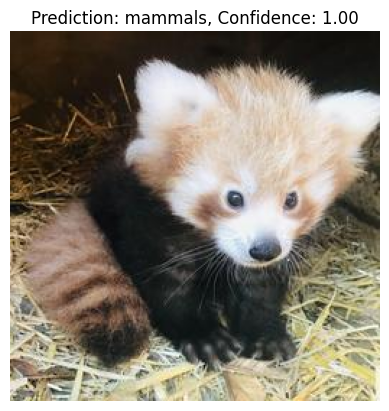

In [ ]:
# Jalankan fungsi prediksi dan tampilkan gambar
predict_and_display_image(folder_path)

In [ ]:
import pkg_resources

# Mendapatkan semua library yang diimpor
installed_packages = pkg_resources.working_set
requirements = sorted([f"{pkg.key}=={pkg.version}" for pkg in installed_packages])

# Simpan ke file requirements.txt
with open('requirements.txt', 'w') as f:
    f.write('\n'.join(requirements))

# Unduh file requirements.txt
from google.colab import files
files.download('requirements.txt')

<ipython-input-55-e53785d33ec8>:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>